In [0]:
!python -m textblob.download_corpora

In [0]:
!python -m spacy download en_core_web_lg

In [0]:
import warnings
warnings.filterwarnings('ignore')

import re
from textblob import TextBlob
import numpy as np
import io
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import seaborn as sns
from textblob.sentiments import NaiveBayesAnalyzer
from textblob import Word
import matplotlib.pyplot as plt
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [4]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
%%time
df = pd.read_csv('/content/drive/My Drive/noemoticon.csv',encoding='latin1',header=None)
df = reduce_mem_usage(df)

Memory usage of dataframe is 73.24 MB --> 62.56 MB (Decreased by 14.6%)
CPU times: user 3.97 s, sys: 802 ms, total: 4.77 s
Wall time: 5.18 s


In [7]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [0]:
df=df[[5,0]]

In [0]:
df.columns=['twitts','sentiment']

In [10]:
df.head()

,twitts,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [11]:
column= df.columns

for i in column:
  print(f"unique [{i}] ",df[i].value_counts() )

unique [twitts]  isPlayer Has Died! Sorry                                                                                                           210
good morning                                                                                                                       118
headache                                                                                                                           115
Good morning                                                                                                                       112
Headache                                                                                                                           106
                                                                                                                                  ... 
Bagel with peanutbutter. Yummy                                                                                                       1
@Holla_x777 man, everyone has seen thi

In [12]:
df['sentiment'].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [0]:
sent_map = {0:'negative',4:'positive'}

**WORD COUNT**

In [0]:
df['word_count'] = df['twitts'].apply(lambda x: len(str(x).split()))

**CHARACTER COUNT**

In [0]:
df['char_count'] = df['twitts'].apply(lambda x: len(x))

In [16]:
df.head()

,twitts,sentiment,word_count,char_count
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,19,115
1,is upset that he can't update his Facebook by ...,0,21,111
2,@Kenichan I dived many times for the ball. Man...,0,18,89
3,my whole body feels itchy and like its on fire,0,10,47
4,"@nationwideclass no, it's not behaving at all....",0,21,111


AVERAGE WORD LENGTH
**bold text**
```
# This is formatted as code
```



In [0]:
def get_avg_word_len(x):
  words = x.split()
  word_len = 0
  for word in words:
    word_len = word_len + len(word)
  return word_len/len(words)

In [0]:
df['avg_word_len'] = df['twitts'].apply(lambda x: get_avg_word_len(x))

In [19]:
df.head()

,twitts,sentiment,word_count,char_count,avg_word_len
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,19,115,5.052632
1,is upset that he can't update his Facebook by ...,0,21,111,4.285714
2,@Kenichan I dived many times for the ball. Man...,0,18,89,3.944444
3,my whole body feels itchy and like its on fire,0,10,47,3.700000
4,"@nationwideclass no, it's not behaving at all....",0,21,111,4.285714


  STOP WORD COUNT
**bold text**  

In [20]:
print(STOP_WORDS)

{'namely', 'herein', 'should', 'become', 'i', 'bottom', 'latterly', 'top', 'toward', 'there', 'back', '’ve', 'ever', 'other', 'could', 'to', 'perhaps', 'anywhere', 'whoever', 'those', 'either', 'his', 'third', 'above', 'they', 'be', 'see', 'done', 'seem', 'been', 'myself', 'that', 'over', 'this', 'during', 'here', 'everything', "'m", 'against', 'seeming', 'he', '‘ve', 'who', 'even', 'whereafter', '’ll', 'around', 'name', 'ourselves', 'same', 'thence', 'noone', 'into', 'within', 'sometimes', 'wherever', 'how', 'made', 'among', 'somewhere', 'due', 'since', 'between', 'give', 're', 'almost', 'as', 'six', "'ll", 'these', 'unless', "'d", 'afterwards', 'quite', 'ca', 'fifteen', 'becomes', 'in', 'therefore', 'when', 'are', 'herself', 'on', 'while', '‘s', 'own', 'side', '‘d', 'will', 'below', 'whose', 'them', '‘ll', 'n’t', 'each', '‘re', 'were', 'with', 'would', 'behind', 'itself', 'one', 'hence', 'latter', 'anyway', 'its', 'much', 'several', 'under', 'just', 'per', 'serious', 'front', 'howeve

In [0]:
df['stop_words_len']=df['twitts'].apply(lambda x:len([t for t in x.split() if t in STOP_WORDS]))

In [22]:
df.head()

,twitts,sentiment,word_count,char_count,avg_word_len,stop_words_len
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,19,115,5.052632,4
1,is upset that he can't update his Facebook by ...,0,21,111,4.285714,9
2,@Kenichan I dived many times for the ball. Man...,0,18,89,3.944444,7
3,my whole body feels itchy and like its on fire,0,10,47,3.700000,5
4,"@nationwideclass no, it's not behaving at all....",0,21,111,4.285714,10


**COUNT #HASTAGS AND @ MENTIONS**

In [0]:
df['hashtags_count']= df['twitts'].apply(lambda x:len([t for t in x.split() if t.startswith('#') ]))
df['mentions_count']= df['twitts'].apply(lambda x:len([t for t in x.split() if t.startswith('@') ]))

**IF NUMERIC DIGITS IN TWEETS**

In [0]:
df['numerics_count'] = df['twitts'].apply(lambda x:len([t for t in x.split() if t.isdigit()]))

**UPPER CASE WORD COUNT**

In [0]:
df['upper_count'] = df['twitts'].apply(lambda x: len([t for t in x.split() if t.isupper() and len(x) >3]))

In [26]:
df.head()

,twitts,sentiment,word_count,char_count,avg_word_len,stop_words_len,hashtags_count,mentions_count,numerics_count,upper_count
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,19,115,5.052632,4,0,1,0,1
1,is upset that he can't update his Facebook by ...,0,21,111,4.285714,9,0,0,0,0
2,@Kenichan I dived many times for the ball. Man...,0,18,89,3.944444,7,0,1,0,1
3,my whole body feels itchy and like its on fire,0,10,47,3.700000,5,0,0,0,0
4,"@nationwideclass no, it's not behaving at all....",0,21,111,4.285714,10,0,1,0,1


**PREPROCESSING AND CLEANING**

**LOWER CASE CONVERSION**

In [0]:
df['twitts'] = df['twitts'].apply(lambda x:x.lower())

***CONTRACTION TO EXPANSION***

In [0]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and "}

In [0]:
def cont_to_exp(x):
  if type(x) is str:
    for key in contractions:
      value = contractions[key]
      x= x.replace(key,value)
    return x
  else:
     return x

In [30]:
%%time
df['twitts']=df['twitts'].apply(lambda x:cont_to_exp(x))

CPU times: user 32.4 s, sys: 140 ms, total: 32.5 s
Wall time: 32.6 s


**REMOVE EMAILS**

In [0]:
df['emails'] = df['twitts'].apply(lambda x: re.findall(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)',x))

In [0]:
df['emails_count'] = df['emails'].apply(lambda x:len(x))

In [0]:
#Removes all emails for the dataset
df['twitts']= df['twitts'].apply(lambda x:re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)','',x))

**COUNT URLS AND REMOVE**

In [0]:
df['urls_flag'] = df['twitts'].apply(lambda x: len(re.findall(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', x)))

In [0]:
#Removing all urls
df['twitts'] = df['twitts'].apply(lambda x: re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', x))

**RETWEETS**

In [0]:
#Remove Retweets
df['twitts'] = df['twitts'].apply(lambda x: re.sub('RT',"",x))

**REMOVE SPECIAL CHARACTERS FROM DATASET**

In [0]:
df['twitts'] =df['twitts'].apply(lambda x: re.sub('[^A-Z a-z 0-9-]+', '', x))

**REMOVE MULTIPLE SPACES**

In [0]:
df['twitts']=df['twitts'].apply(lambda x:" ".join(x.split()))

In [39]:
df.head()

,twitts,sentiment,word_count,char_count,avg_word_len,stop_words_len,hashtags_count,mentions_count,numerics_count,upper_count,emails,emails_count,urls_flag
0,switchfoot - awww that is a bummer you shoulda...,0,19,115,5.052632,4,0,1,0,1,[],0,1
1,is upset that he cannot update his facebook by...,0,21,111,4.285714,9,0,0,0,0,[],0,0
2,kenichan i dived many times for the ball manag...,0,18,89,3.944444,7,0,1,0,1,[],0,0
3,my whole body feels itchy and like its on fire,0,10,47,3.700000,5,0,0,0,0,[],0,0
4,nationwideclass no it is not behaving at all i...,0,21,111,4.285714,10,0,1,0,1,[],0,0


**REMOVE HTML TAGS**

In [0]:
df['twitts'] = df['twitts'].apply(lambda x: BeautifulSoup(x,'lxml').get_text())

**REMOVE CHARACTERS WHICH ARE NOT IN ENGLISH LIKE SPECIAL LETTERS IN TURKISH, ENGLISH**

In [0]:
def remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

In [0]:
df['twitts'] = df['twitts'].apply(lambda x: remove_accented_chars(x))

**REMOVE STOP WORDS**

In [0]:
df['twitts'] = df['twitts'].apply(lambda x:" ".join([t for t in x.split() if t not in STOP_WORDS]))

**CONVERT TO BASE OR ROOT FORM OF WORD**

In [0]:
nlp = spacy.load('en_core_web_sm')

In [0]:
#The dataset is huge and i do not have the computational resources to apply this but
#below is a sample useage of this function
def make_to_base(x):
  """
  Beware of your computational resources because
  this function could take days to completely run on 
  such a huge Dataset
  Thanks :)
  """
  x_list =[]
  doc =nlp(x)
  for token in doc:
    lemma=str(token.lemma_)
    if lemma =='-PRON-' or lemma == 'be':
      lemma = token.text
    x_list.append(lemma)
  print(" ".join(x_list))

In [0]:
x= 'the man dives in the the pool everyday and never manages his time appropriately'

In [47]:
#Sample implementation of converting words to their base form
make_to_base(x)


the man dive in the the pool everyday and never manage his time appropriately


**`REMOVING WORDS WITH MULTIPLE FREQUENCY IN THE DATASET`**

The useage of this depends on your needs

In [0]:
text = ' '.join(df['twitts'])

In [0]:
text = text.split()

In [0]:
freq_comm = pd.Series(text).value_counts()

In [0]:
#Top 20 most occuring words

f20 =freq_comm[:20]

In [0]:
df['twitts']=df['twitts'].apply(lambda x:" ".join([t for t in x.split() if t not in f20]))

**REMOVE RARE WORDS**

In [0]:
rare100 = freq_comm[:-100]

In [0]:
#This is a list of all the least occuring words to save time i wont use this but you definite can
rare = freq_comm[freq_comm.values == 1]

In [0]:
df['twitts']=df['twitts'].apply(lambda x: ' '.join([t for t in x.split() if t not in rare100]))

**WORD CLOUD VISUALIZATION**

In [56]:
len(text)

10837079

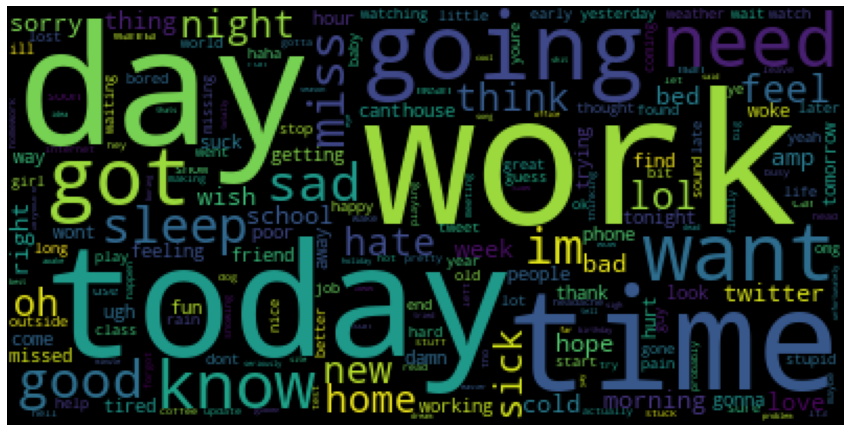

In [57]:
#The image quality is bad because ive increased the image size
plt.figure(figsize=(15,10))
x = " ".join(text[:50000])
wc = WordCloud().generate(x)
plt.imshow(wc)
plt.axis('off')
plt.show()

**SPELLING CORRECTION**



In [0]:
x='tanks forr waching these vidios carr'

In [0]:
x = TextBlob(x).correct()

In [60]:
x

TextBlob("tanks for watching these vicious care")

**TOKENIZATION**

In [0]:
x = 'thanks for watching this video. please like it'

In [62]:
TextBlob(x).words

WordList(['thanks', 'for', 'watching', 'this', 'video', 'please', 'like', 'it'])

***TOKENIZATION WTIH SPACY***

In [63]:
doc = nlp(x)

for token in doc:
  print(token)

thanks
for
watching
this
video
.
please
like
it


**LEMMATIZATION**

In [0]:
x = 'runs run ran running ranned'

In [65]:
for token in x.split():
  print(Word(token).lemmatize())

run
run
ran
running
ranned


In [66]:
doc = nlp(x)
for token in doc:
  print(token.lemma_)

run
run
run
run
ranned


**DETECT ENTITIES USING NER OF SpaCy**

In [0]:
x = 'Breaking News. Donaly Trump, the president of teh USA is looking for resources, to mine the Moon together with the CEO of Tesla Elon Musk and Bill Gates is just watching from universe 616'

In [68]:
doc = nlp(x)
for ent in doc.ents:
  print(ent.text + '  - ' + ent.label_ + "  - " + str(spacy.explain(ent.label_)))

Breaking News  - ORG  - Companies, agencies, institutions, etc.
Donaly Trump  - PERSON  - People, including fictional
teh USA  - ORG  - Companies, agencies, institutions, etc.
Moon  - PERSON  - People, including fictional
Tesla Elon Musk  - WORK_OF_ART  - Titles of books, songs, etc.
Bill Gates  - PERSON  - People, including fictional
616  - CARDINAL  - Numerals that do not fall under another type


In [69]:
displacy.render(doc, style= 'dep',)

'<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" xml:lang="en" id="59148cb8560b42979b4c474e2305922c-0" class="displacy" width="6000" height="662.0" direction="ltr" style="max-width: none; height: 662.0px; color: #000000; background: #ffffff; font-family: Arial; direction: ltr">\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">\n    <tspan class="displacy-word" fill="currentColor" x="50">Breaking</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="50">VERB</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">\n    <tspan class="displacy-word" fill="currentColor" x="225">News.</tspan>\n    <tspan class="displacy-tag" dy="2em" fill="currentColor" x="225">PROPN</tspan>\n</text>\n\n<text class="displacy-token" fill="currentColor" text-anchor="middle" y="572.0">\n    <tspan class="displacy-word" fill="currentColor" x="400">Donaly</tspan>\n    <tspan class="di

**DETECING NOUNS**

In [70]:
for noun in doc.noun_chunks:
  print(noun)

Breaking News
Donaly Trump
the president
teh USA
resources
the Moon
the CEO
Tesla Elon Musk
Bill Gates
universe


**TRANSLATION AND LANGUAGE DETECTION**

In [0]:
tb= TextBlob(x)

In [72]:
tb.detect_language()

'en'

In [73]:
tb.translate(to='zh')

TextBlob("爆炸新闻。美国总统唐纳利·特朗普（Donaly Trump）正在寻找资源，与特斯拉埃隆·马斯克（Tesla Elon Musk）的首席执行官一起开采月球，而比尔·盖茨（Bill Gates）只是从宇宙616观察")

**USE INBUILT SENTIMENT CLASSIFIER**

In [0]:
x = 'we all stand  together to fight against corona.We will win together'

In [0]:
tb = TextBlob(x,analyzer=NaiveBayesAnalyzer())

In [76]:
tb.sentiment

Sentiment(classification='pos', p_pos=0.7620286649293809, p_neg=0.23797133507062)

**ADVANCE TEXT PROCESSING**

**N-GRAMS **(combination of multiple words use togethe)

In [0]:
x = 'thanks for watching'

tb= TextBlob(x)


In [78]:
tb.ngrams(2)

[WordList(['thanks', 'for']), WordList(['for', 'watching'])]

**BAG OF WORDS**

simplest model to extract features from text data

In [0]:
x = ['this is the first sentence this is ','this is  sentence the second ', 'this is the lase']

In [0]:
cv = CountVectorizer(ngram_range=(1,1))
text_counts = cv.fit_transform(x)

In [81]:
text_counts

<3x7 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [0]:
#unique words in the sentence
cv_features =cv.get_feature_names(
    
)

In [83]:
text_counts.toarray()

array([[1, 2, 0, 0, 1, 1, 2],
       [0, 1, 0, 1, 1, 1, 1],
       [0, 1, 1, 0, 0, 1, 1]])

In [0]:
bow = pd.DataFrame(text_counts.toarray(), columns=cv_features)

In [85]:
bow #show the number of accuracy of each word in the sentence

,first,is,lase,second,sentence,the,this
0,1,2,0,0,1,1,2
1,0,1,0,1,1,1,1
2,0,1,1,0,0,1,1


**TERM FREQUENCY**

shows the ratio of count the count of a word present in a sentence , to the lenght of the sentence

In [86]:
x

['this is the first sentence this is ',
 'this is  sentence the second ',
 'this is the lase']

In [87]:
bow

,first,is,lase,second,sentence,the,this
0,1,2,0,0,1,1,2
1,0,1,0,1,1,1,1
2,0,1,1,0,0,1,1


In [88]:
bow.shape

(3, 7)

In [0]:
tf = bow.copy()

In [90]:
tf

,first,is,lase,second,sentence,the,this
0,1,2,0,0,1,1,2
1,0,1,0,1,1,1,1
2,0,1,1,0,0,1,1


In [0]:
for index,row in enumerate(tf.iterrows()):
  for col in row[1].index:
    tf.loc[index, col] = tf.loc[index, col]/sum(row[1].values)

In [92]:
#bag of words is now  ter frequen7
bow

,first,is,lase,second,sentence,the,this
0,1,2,0,0,1,1,2
1,0,1,0,1,1,1,1
2,0,1,1,0,0,1,1


**INVERSE DOCUMENT FREQUENCY**

> idf = log( (1 + N)/(n + 1)) + 1 used in sklearn when smooth_idf = True

> where, N is the total number of rows and n is the number of rows in which the word was present.



In [0]:
x_df = pd.DataFrame(x, columns=['words'])

In [94]:
x_df

,words
0,this is the first sentence this is
1,this is sentence the second
2,this is the lase


In [95]:
N = bow.shape[0]
N

3

In [96]:
bb = bow.astype('bool')
bb

,first,is,lase,second,sentence,the,this
0,True,True,False,False,True,True,True
1,False,True,False,True,True,True,True
2,False,True,True,False,False,True,True


In [97]:
bb['first'].sum()

1

In [98]:
cols = bb.columns
cols

Index(['first', 'is', 'lase', 'second', 'sentence', 'the', 'this'], dtype='object')

In [0]:
nz=[]
for col in cols:
  nz.append(bb[col].sum())


In [100]:
nz

[1, 3, 1, 1, 2, 3, 3]

In [0]:
idf = []
for index, col in enumerate(cols):
    idf.append(np.log((N + 1)/(nz[index] + 1)) + 1)

In [102]:
idf

[1.6931471805599454,
 1.0,
 1.6931471805599454,
 1.6931471805599454,
 1.2876820724517808,
 1.0,
 1.0]

**TFIDF : TERM FREQUENCY INVERSE DOCUMENT FREQUENCY**

In [0]:
tfidf = TfidfVectorizer()
x_tfidf = tfidf.fit_transform(x_df['words'])


In [104]:
tfidf.idf_

array([1.69314718, 1.        , 1.69314718, 1.69314718, 1.28768207,
       1.        , 1.        ])

In [105]:
idf

[1.6931471805599454,
 1.0,
 1.6931471805599454,
 1.6931471805599454,
 1.2876820724517808,
 1.0,
 1.0]

**WORD EMBEDDINGS**

In [0]:
nlp= spacy.load('en_core_web_lg')

In [0]:
doc= nlp('thank you! dog cat lion chowa')

In [110]:
for token in doc:
  print(token.text, token.has_vector)

thank True
you True
! True
dog True
cat True
lion True
chowa False


In [111]:
nlp('cat').vector.shape

(300,)

In [112]:
#checking for similarities in the sentence
for token1 in doc:
  for token2 in doc:
    print(token1.text, token2.text, token1.similarity(token2))
    print()

thank thank 1.0

thank you 0.56475854

thank ! 0.52147406

thank dog 0.25042647

thank cat 0.20648488

thank lion 0.13629763

thank chowa 0.0

you thank 0.56475854

you you 1.0

you ! 0.4390223

you dog 0.364941

you cat 0.3080798

you lion 0.20392053

you chowa 0.0

! thank 0.52147406

! you 0.4390223

! ! 1.0

! dog 0.29852206

! cat 0.29702345

! lion 0.19601384

! chowa 0.0

dog thank 0.25042647

dog you 0.364941

dog ! 0.29852206

dog dog 1.0

dog cat 0.80168545

dog lion 0.47424486

dog chowa 0.0

cat thank 0.20648488

cat you 0.3080798

cat ! 0.29702345

cat dog 0.80168545

cat cat 1.0

cat lion 0.5265438

cat chowa 0.0

lion thank 0.13629763

lion you 0.20392053

lion ! 0.19601384

lion dog 0.47424486

lion cat 0.5265438

lion lion 1.0

lion chowa 0.0

chowa thank 0.0

chowa you 0.0

chowa ! 0.0

chowa dog 0.0

chowa cat 0.0

chowa lion 0.0

chowa chowa 1.0



**MACHINE LEARNING MODELS FOR TEXT CLASSIFIFCATION**

In [130]:
df

,twitts,sentiment,word_count,char_count,avg_word_len,stop_words_len,hashtags_count,mentions_count,numerics_count,upper_count,emails,emails_count,urls_flag
0,,0,19,115,5.052632,4,0,1,0,1,[],0,1
1,,0,21,111,4.285714,9,0,0,0,0,[],0,0
2,,0,18,89,3.944444,7,0,1,0,1,[],0,0
3,,0,10,47,3.700000,5,0,0,0,0,[],0,0
4,,0,21,111,4.285714,10,0,1,0,1,[],0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599995,,4,11,56,4.090909,4,0,0,0,0,[],0,0
1599996,,4,11,78,6.090909,1,0,0,0,0,[],0,1
1599997,,4,11,57,4.181818,5,0,0,0,0,[],0,0
1599998,,4,12,65,4.416667,3,0,0,0,0,[],0,0


In [131]:
df.shape

(1600000, 13)

In [0]:
df0 = df[df['sentiment']==0].sample(20000)
df4 = df[df['sentiment']==4].sample(20000)

In [0]:
dfr = df0.append(df4)

In [155]:
dfr.shape

(40000, 13)

In [156]:
dfr

,twitts,sentiment,word_count,char_count,avg_word_len,stop_words_len,hashtags_count,mentions_count,numerics_count,upper_count,emails,emails_count,urls_flag
181758,,0,26,134,4.115385,10,0,1,0,2,[],0,0
392276,,0,17,86,4.058824,7,0,0,1,0,[],0,0
537935,,0,24,124,4.125000,12,1,2,0,1,[],0,0
297330,,0,15,89,4.933333,5,0,1,0,1,[],0,0
95251,,0,12,78,5.416667,3,0,0,0,0,[],0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
842852,,4,20,112,4.600000,12,0,0,0,1,[],0,0
1232646,,4,10,51,4.100000,4,0,0,0,1,[],0,0
1012766,,4,9,54,5.000000,2,0,1,0,0,[],0,0
889028,,4,5,33,5.600000,1,0,1,0,0,[],0,0


In [0]:
dfr_feat = dfr.drop(['twitts','sentiment','emails'],axis=1).reset_index(drop=True)

In [0]:
y= dfr['sentiment']

In [161]:
y

181758     0
392276     0
537935     0
297330     0
95251      0
          ..
842852     4
1232646    4
1012766    4
889028     4
1053345    4
Name: sentiment, Length: 40000, dtype: int8

In [0]:
cv= CountVectorizer()

In [0]:
text_counts = cv.fit_transform(dfr['twitts'])

In [164]:
text_counts.toarray().shape

(40000, 2)

In [0]:
dfr_bow = pd.DataFrame(text_counts.toarray(), columns=cv.get_feature_names())

In [166]:
dfr_bow

,bummersorry,unitedcardists
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
39995,0,0
39996,0,0
39997,0,0
39998,0,0


**MACHINE LEARNING ALGORITHMS**

In [0]:
sgd = SGDClassifier(n_jobs=-1, random_state=42, max_iter=200)
lgr = LogisticRegression(random_state=42, max_iter=200)
lgrcv = LogisticRegressionCV(cv = 2, random_state=42, max_iter=1000)
svm = LinearSVC(random_state=42, max_iter=200)
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=200)

In [0]:
clf = {'SGD': sgd, 'LGR': lgr, 'LGR-CV': lgrcv, 'SVM': svm, 'RFC': rfc}

In [0]:
def classify(X, y):
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
    
    for key in clf.keys():
        clf[key].fit(X_train, y_train)
        y_pred = clf[key].predict(X_test)
        ac = accuracy_score(y_test, y_pred)
        print(key, " ---> ", ac)

In [170]:
%%time
classify(dfr_bow,y)

SGD  --->  0.5
LGR  --->  0.5
LGR-CV  --->  0.5
SVM  --->  0.5
RFC  --->  0.5
CPU times: user 1.94 s, sys: 390 ms, total: 2.33 s
Wall time: 1.37 s


In [171]:
dfr_feat

,word_count,char_count,avg_word_len,stop_words_len,hashtags_count,mentions_count,numerics_count,upper_count,emails_count,urls_flag
181758,26,134,4.115385,10,0,1,0,2,0,0
392276,17,86,4.058824,7,0,0,1,0,0,0
537935,24,124,4.125000,12,1,2,0,1,0,0
297330,15,89,4.933333,5,0,1,0,1,0,0
95251,12,78,5.416667,3,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
842852,20,112,4.600000,12,0,0,0,1,0,0
1232646,10,51,4.100000,4,0,0,0,1,0,0
1012766,9,54,5.000000,2,0,1,0,0,0,0
889028,5,33,5.600000,1,0,1,0,0,0,0


**MANUAL FEATURES**

In [172]:
%%time

classify(dfr_feat,y)

SGD  --->  0.592625
LGR  --->  0.599875
LGR-CV  --->  0.600125
SVM  --->  0.6005
RFC  --->  0.55375
CPU times: user 14.7 s, sys: 1.91 s, total: 16.6 s
Wall time: 8.7 s


**MANUAL FEATURES + BAG OF WORDS**

In [0]:
X=dfr_feat.join(dfr_bow)

In [178]:
X

,word_count,char_count,avg_word_len,stop_words_len,hashtags_count,mentions_count,numerics_count,upper_count,emails_count,urls_flag,bummersorry,unitedcardists
0,26,134,4.115385,10,0,1,0,2,0,0,0,0
1,17,86,4.058824,7,0,0,1,0,0,0,0,0
2,24,124,4.125000,12,1,2,0,1,0,0,0,0
3,15,89,4.933333,5,0,1,0,1,0,0,0,0
4,12,78,5.416667,3,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
39995,20,112,4.600000,12,0,0,0,1,0,0,0,0
39996,10,51,4.100000,4,0,0,0,1,0,0,0,0
39997,9,54,5.000000,2,0,1,0,0,0,0,0,0
39998,5,33,5.600000,1,0,1,0,0,0,0,0,0


In [179]:
%%time
classify(X,y)

SGD  --->  0.5925
LGR  --->  0.599625
LGR-CV  --->  0.6
SVM  --->  0.6005
RFC  --->  0.55625
CPU times: user 14.4 s, sys: 1.89 s, total: 16.3 s
Wall time: 8.57 s


**TFIDF**

In [0]:
tfidf = TfidfVectorizer()

In [0]:
X=tfidf.fit_transform(dfr['twitts'])

In [183]:
%%time

classify(pd.DataFrame(X.toarray()),y)

SGD  --->  0.5
LGR  --->  0.5
LGR-CV  --->  0.5
SVM  --->  0.5
RFC  --->  0.5
CPU times: user 1.91 s, sys: 453 ms, total: 2.36 s
Wall time: 1.52 s


**WORD2Vec**

In [0]:
def get_vec(x):
  doc = nlp(x)
  return doc.vector.reshape(1,-1)

In [185]:
%%time
dfr['vec']=dfr['twitts'].apply(lambda x:get_vec(x))

CPU times: user 1.43 s, sys: 15.8 ms, total: 1.44 s
Wall time: 1.44 s


In [0]:
X=np.concatenate(dfr['vec'].to_numpy(),axis=0)

In [187]:
X.shape

(40000, 300)

In [188]:
classify(pd.DataFrame(X),y)

SGD  --->  0.5
LGR  --->  0.5
LGR-CV  --->  0.5
SVM  --->  0.5
RFC  --->  0.5


In [0]:
def predict_w2v(x):
  for key in clf.keys():
    y_pred = clf[key].predict(get_vec(x))
    print(key, " --->",y_pred)

In [194]:
predict_w2v('love')

SGD  ---> [0]
LGR  ---> [0]
LGR-CV  ---> [0]
SVM  ---> [4]
RFC  ---> [4]


In [192]:
predict_w2v('i will kill you ')

SGD  ---> [0]
LGR  ---> [0]
LGR-CV  ---> [0]
SVM  ---> [4]
RFC  ---> [4]


In [193]:
"""
increasing the data size and fine tuning the model will definitey producte
better results
"""

'\nincreasing the data size and fine tuning the model will definitey producte\nbetter results\n'